<a href="https://colab.research.google.com/github/ny-yo/KK_proto/blob/main/vgg16/vgg16_finetune_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#vgg16をfinetuneして犬猫の画像分類するpythonプログラム (trainパート)  
#下記を参考  
#https://qiita.com/yottyann1221/items/20a9c8a7a02edc7cd3d1

Google Driveをマウント

In [1]:
from google.colab import drive #インポート
drive.mount('/content/drive/') #GoogleDriveのマウント

Mounted at /content/drive/


ライブラリの読み込み

In [2]:
import os
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import numpy as np
import time

事前に設定するパラメータ

In [3]:
# 分類するクラス
classes = ["cat", "dog"]
nb_classes = len(classes)
#画像の大きさを設定
img_width, img_height = 150, 150

# トレーニング用とバリデーション用の画像格納先（パスは自分で設定してください）
train_data_dir = '/content/drive/MyDrive/KK_proto/fine_tune/train'
validation_data_dir = '/content/drive/MyDrive/KK_proto/fine_tune/valid'

#steps_per_epoch = len(X_train)//batch_size
#https://stackoverflow.com/questions/59864408/tensorflowyour-input-ran-out-of-data
nb_train_samples = 32
nb_validation_samples = 12
#バッチサイズ
batch_size = 32
#エポック数
nb_epoch = 20

トレーンング用、バリデーション用データを生成するジェネレータ作成

In [4]:
# トレーンング用、バリデーション用データを生成するジェネレータ作成
train_datagen = ImageDataGenerator(
  rescale=1.0 / 255,
  #すでに画像の水増し済みの方は、下記２行は必要ありません。
  #zoom_range=0.2,
  #horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [5]:
train_generator = train_datagen.flow_from_directory(
  train_data_dir,
  target_size=(img_width, img_height),
  color_mode='rgb',
  classes=classes,
  class_mode='categorical',
  batch_size=batch_size,
  shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
  validation_data_dir,
  target_size=(img_width, img_height),
  color_mode='rgb',
  classes=classes,
  class_mode='categorical',
  batch_size=batch_size,
  shuffle=True)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


モデルの構築

In [6]:
# VGG16のロード。FC層は不要なので include_top=False
input_tensor = Input(shape=(img_width, img_height, 3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# VGG16の図の緑色の部分（FC層）の作成
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(nb_classes, activation='softmax'))

# VGG16とFC層を結合してモデルを作成（完成図が上の図）
vgg_model = Model(vgg16.input, top_model(vgg16.output))

# VGG16の図の青色の部分は重みを固定（frozen）
for layer in vgg_model.layers[:15]:
    layer.trainable = False

# 多クラス分類を指定
vgg_model.compile(loss='categorical_crossentropy',
          optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
          metrics=['accuracy'])

58900480/58889256 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


モデルの学習

In [7]:
# Fine-tuning
history = vgg_model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples,
    epochs=nb_epoch,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples
    )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
32/32 [==============================] - 479s 14s/step - loss: 0.7391 - accuracy: 0.6132 - val_loss: 0.3540 - val_accuracy: 0.8333
Epoch 2/20
32/32 [==============================] - 235s 7s/step - loss: 0.2969 - accuracy: 0.8718 - val_loss: 0.2059 - val_accuracy: 0.9219
Epoch 3/20
32/32 [==============================] - 103s 3s/step - loss: 0.2306 - accuracy: 0.9160 - val_loss: 0.2133 - val_accuracy: 0.9193
Epoch 4/20
32/32 [==============================] - 53s 2s/step - loss: 0.1707 - accuracy: 0.9354 - val_loss: 0.2136 - val_accuracy: 0.9062
Epoch 5/20
32/32 [==============================] - 31s 966ms/step - loss: 0.1060 - accuracy: 0.9720 - val_loss: 0.2070 - val_accuracy: 0.9271
Epoch 6/20
32/32 [==============================] - 13s 428ms/step - loss: 0.1652 - accuracy: 0.9352 - val_loss: 0.1850 - val_accuracy: 0.9323
Epoch 7/20
32/32 [==============================] - 11s 348ms/step - loss: 0.1244 - accuracy: 0.9586 - val_loss: 0.2995 - val_accuracy: 0.8542
Epoch 8

モデルの評価

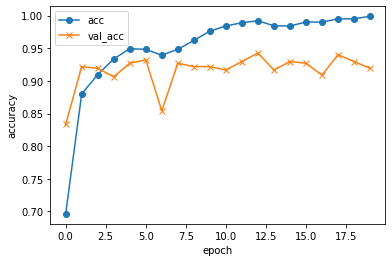

In [8]:
# 学習結果を描写
import matplotlib.pyplot as plt

#acc, val_accのプロット
plt.plot(history.history["accuracy"], label="acc", ls="-", marker="o")
plt.plot(history.history["val_accuracy"], label="val_acc", ls="-", marker="x")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
#Final.pngという名前で、結果を保存
plt.savefig('Final.png')
plt.show()

モデルの重みを保存

In [9]:
#resultsディレクトリを作成
result_dir = '/content/drive/MyDrive/KK_proto/fine_tune/result'
if not os.path.exists(result_dir):
    os.mkdir(result_dir)

# 重みを保存
vgg_model.save_weights(os.path.join(result_dir, 'Final.h5'))

# 作成したモデルを保存
# vgg_model.save('VGGtake1.h5')